# Project: Dog vs Cat Classification

In [268]:
from pathlib import Path
import os
import torch
from torch import nn

In [269]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [270]:
data_path = Path("data/")
train_path = data_path / "train"
test_path = data_path / "test"

train_path, test_path

(WindowsPath('data/train'), WindowsPath('data/test'))

In [271]:
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np

Text(0.5, 1.0, 'Dog, Shape: (351, 400, 3)')

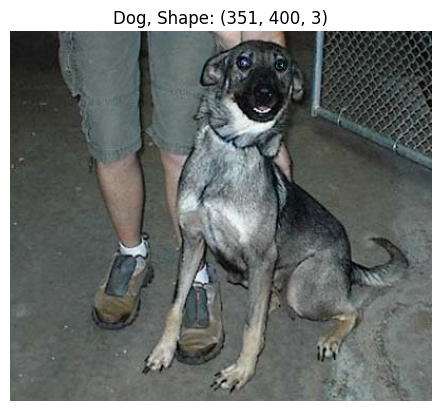

In [272]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
image_path_list = list(data_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)
img_is_array = np.asarray(img)

plt.imshow(img)
plt.axis(False)
plt.title(f"{image_class}, Shape: {img_is_array.shape}")

In [273]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [274]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [275]:
transformed_image = data_transform(img)
transformed_image

tensor([[[0.1176, 0.1137, 0.1137,  ..., 0.1765, 0.1725, 0.1686],
         [0.1020, 0.1059, 0.1137,  ..., 0.1412, 0.1725, 0.1569],
         [0.1020, 0.1020, 0.1098,  ..., 0.1725, 0.1373, 0.1804],
         ...,
         [0.3961, 0.3922, 0.3843,  ..., 0.4431, 0.4118, 0.4196],
         [0.3922, 0.3765, 0.3647,  ..., 0.4588, 0.4275, 0.4353],
         [0.3765, 0.3843, 0.3725,  ..., 0.4588, 0.4392, 0.4431]],

        [[0.1176, 0.1137, 0.1137,  ..., 0.1882, 0.1961, 0.2078],
         [0.1020, 0.1059, 0.1137,  ..., 0.1529, 0.1961, 0.1922],
         [0.1020, 0.1020, 0.1098,  ..., 0.1843, 0.1569, 0.2118],
         ...,
         [0.4157, 0.4078, 0.4039,  ..., 0.4784, 0.4392, 0.4353],
         [0.4118, 0.3961, 0.3843,  ..., 0.5020, 0.4588, 0.4510],
         [0.3961, 0.4039, 0.3922,  ..., 0.4980, 0.4706, 0.4588]],

        [[0.1176, 0.1137, 0.1137,  ..., 0.2000, 0.2039, 0.1922],
         [0.1020, 0.1059, 0.1137,  ..., 0.1569, 0.2000, 0.1922],
         [0.1020, 0.1020, 0.1098,  ..., 0.1765, 0.1569, 0.

Text(0.5, 1.0, 'Dog, Shape: torch.Size([3, 64, 64])')

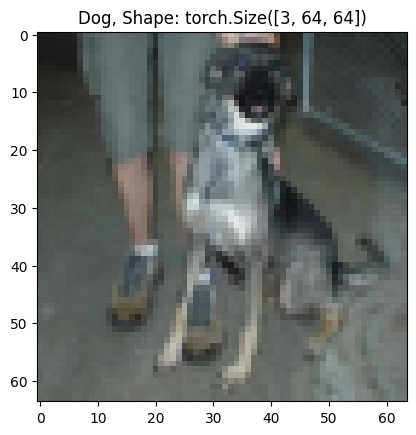

In [276]:
plt.imshow(transformed_image.permute(1, 2, 0))
plt.title(f"{image_class}, Shape: {transformed_image.shape}")

# Loading data using 'ImageFolder'

In [277]:
train_data = datasets.ImageFolder(root=train_path,
                                  transform=data_transform)

test_data = datasets.ImageFolder(root=test_path,
                                 transform=test_data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 1326
     Root location: data\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 275
     Root location: data\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [278]:
# Get class names as list
class_names = train_data.classes
class_names

['Cat', 'Dog']

In [279]:
# Get class names as dictionary 
class_dict = train_data.class_to_idx
class_dict

{'Cat': 0, 'Dog': 1}

In [280]:
len(train_data), len(test_data)

(1326, 275)

# Turn loaded images into 'DataLoader'

In [281]:
BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x206b17b9ca0>,
 <torch.utils.data.dataloader.DataLoader at 0x206b17b9d00>)

In [282]:
img_custom, label_custom = next(iter(train_dataloader))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [283]:
class DogVsCat(nn.Module):
    def __init__(self, input_shape, hidden_layers, output_shape):
        super().__init__()

        self.conv_block_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_layers,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=hidden_layers,
                      out_channels=hidden_layers,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.conv_block_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_layers,
                      out_channels=hidden_layers,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=hidden_layers,
                      out_channels=hidden_layers,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers),
            nn.ReLU(),
           # nn.Dropout(p=0.2),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.classification = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_layers*16*16,
                      out_features=output_shape)
        )

    def forward(self, x):
        #print(f"Shape: {x.shape}")
        x = self.conv_block_layer_1(x)
        #print(f"Shape: {x.shape}")
        x = self.conv_block_layer_2(x)
        #print(f"Shape: {x.shape}")
        x = self.classification(x)
        #print(f"Shape: {x.shape}")
        return x
        

In [284]:
model_0 = DogVsCat(input_shape=3, hidden_layers=16, output_shape=1).to(device)
model_0

DogVsCat(
  (conv_block_layer_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_layer_2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification): Seq

In [285]:
# Setup loss function and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

loss_fn, optimizer

(BCEWithLogitsLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [286]:
# Check the correct shape on dummy tensor
dummy_input = torch.randn(32, 3, 64, 64)
output = model_0(dummy_input.to(device))
output

tensor([[ 0.5425],
        [ 0.8484],
        [ 0.0260],
        [ 0.6371],
        [ 0.4360],
        [ 0.0092],
        [ 0.1741],
        [ 0.1367],
        [ 0.2690],
        [ 0.7282],
        [ 0.0833],
        [ 0.4864],
        [ 0.4172],
        [ 0.5457],
        [-0.2539],
        [ 0.1249],
        [ 0.9218],
        [-0.0845],
        [ 0.8316],
        [-0.2329],
        [ 0.3719],
        [ 1.0120],
        [ 0.4694],
        [ 0.0075],
        [ 0.5865],
        [ 0.8826],
        [-0.2252],
        [ 0.2540],
        [ 1.0743],
        [-0.1024],
        [ 0.3356],
        [ 0.6869]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [287]:
from tqdm import tqdm
import time

In [288]:
epochs = 5

start_time = time.time()

results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

for epoch in tqdm(range(epochs)):

    model_0.train()
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        y = y.unsqueeze(dim=1).float()
        
        y_pred = model_0(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = (torch.sigmoid(y_pred) > 0.5).float()
        train_acc += (y_pred_class==y).sum().item() / len(y_pred)

    train_loss /= len(train_dataloader)
    train_acc = (train_acc / len(train_dataloader)) * 100
    
    model_0.eval()
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            X, y = X.to(device), y.to(device)

            y = y.unsqueeze(dim=1).float()
        
            test_pred = model_0(X)

            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_pred_class = (torch.sigmoid(test_pred) > 0.5).float()
            test_acc += (test_pred_class==y).sum().item() / len(test_pred)
    
        test_loss /= len(test_dataloader)
        test_acc = (test_acc / len(test_dataloader)) * 100

    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f} | Test Loss: {test_loss}, Test Accuracy: {test_acc}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    


end_time = time.time()
train_time = end_time - start_time

print(f"Total time: {train_time}")

 20%|██        | 1/5 [00:03<00:12,  3.21s/it]

Epoch: 0 | Train Loss: 0.7624, Train Accuracy: 53.64 | Test Loss: 0.6679492394129435, Test Accuracy: 58.168859649122815


 40%|████      | 2/5 [00:06<00:09,  3.07s/it]

Epoch: 1 | Train Loss: 0.6790, Train Accuracy: 59.05 | Test Loss: 0.6527819434801737, Test Accuracy: 61.20248538011697


 60%|██████    | 3/5 [00:09<00:05,  2.96s/it]

Epoch: 2 | Train Loss: 0.6353, Train Accuracy: 64.82 | Test Loss: 0.6754419671164619, Test Accuracy: 63.541666666666664


 80%|████████  | 4/5 [00:11<00:02,  2.91s/it]

Epoch: 3 | Train Loss: 0.5763, Train Accuracy: 70.40 | Test Loss: 0.6258781552314758, Test Accuracy: 68.60380116959064


100%|██████████| 5/5 [00:14<00:00,  2.94s/it]

Epoch: 4 | Train Loss: 0.5552, Train Accuracy: 71.42 | Test Loss: 0.7043976386388143, Test Accuracy: 65.3874269005848
Total time: 14.714658260345459


# Plot model_0 results

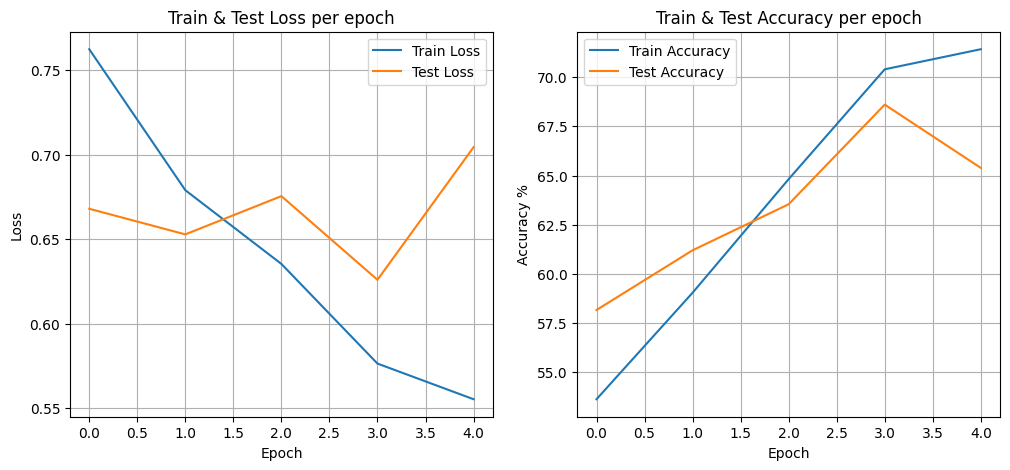

In [289]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), results["train_loss"], label="Train Loss")
plt.plot(range(epochs), results["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Test Loss per epoch")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), results["train_acc"], label="Train Accuracy")
plt.plot(range(epochs), results["test_acc"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy %")
plt.title("Train & Test Accuracy per epoch")
plt.legend()
plt.grid()



In [290]:
print(len(results["train_loss"]), len(results["test_loss"]))
print(len(results["train_acc"]), len(results["test_acc"]))

5 5
5 5


In [291]:
# Build train and test function to make training easier
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim,
               device=device):

    train_loss, correct_preds, total_samples = 0, 0, 0
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y = y.unsqueeze(dim=1).float()
        
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
        y_pred_class = (torch.sigmoid(y_pred) > 0.5).float()
        #train_acc += (y_pred_class==y).sum().item() / len(y_pred)
        correct_preds += (y_pred_class == y).sum().item()
        total_samples += y.size(0)

    train_loss /= len(dataloader)
    #train_acc = (train_acc / len(dataloader)) * 100
    train_acc = (correct_preds / total_samples) * 100
    
    return train_loss, train_acc

In [292]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):

    test_loss, correct_preds, total_samples = 0, 0, 0
    model.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            y = y.unsqueeze(dim=1).float()
        
            test_pred = model(X)

            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_pred_class = (torch.sigmoid(test_pred) > 0.5).float()
            #test_acc += (test_pred_class==y).sum().item() / len(test_pred)
            correct_preds += (test_pred_class == y).sum().item()
            total_samples += y.size(0)
    
    test_loss /= len(dataloader)
    #test_acc = (test_acc / len(dataloader)) * 100
    test_acc = (correct_preds / total_samples) * 100
    return test_loss, test_acc

# Augmentation data

In [293]:
train_data_transform_augmentation = transforms.Compose([
    #transforms.Resize(size=(64, 64)),
    transforms.RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    #transforms.RandomAffine(degrees=15, translate=(1, 1)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # used to differentiate the data
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

test_data = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
train_data_transform_augmentation, test_data

(Compose(
     RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
     RandomHorizontalFlip(p=0.5)
     RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
     ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
     TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
     ToTensor()
     Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
 ),
 Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
     Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
 ))

In [294]:
train_data_augmentation = datasets.ImageFolder(root=train_path,
                                               transform=train_data_transform_augmentation)
test_data_augmentation = datasets.ImageFolder(root=test_path,
                                              transform=test_data)

train_data_augmentation, test_data_augmentation

(Dataset ImageFolder
     Number of datapoints: 1326
     Root location: data\train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
                RandomHorizontalFlip(p=0.5)
                RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
                ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ),
 Dataset ImageFolder
     Number of datapoints: 275
     Root location: data\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Norma

In [295]:
BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader_augmentation = DataLoader(dataset=train_data_augmentation,
                                           batch_size=BATCH_SIZE,
                                           num_workers=NUM_WORKERS,
                                           shuffle=True)

test_dataloader_augmentation = DataLoader(dataset=test_data_augmentation,
                                          batch_size=BATCH_SIZE,
                                          num_workers=NUM_WORKERS,
                                          shuffle=False)

train_dataloader_augmentation, test_dataloader_augmentation

(<torch.utils.data.dataloader.DataLoader at 0x206b4399eb0>,
 <torch.utils.data.dataloader.DataLoader at 0x206b4399d00>)

In [296]:
len(class_names)

2

In [297]:
model_1 = DogVsCat(input_shape=3, hidden_layers=8, output_shape=1).to(device)
model_1

DogVsCat(
  (conv_block_layer_1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_layer_2): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification): Sequential(
  

In [298]:
# Setup loss function and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.00025)
#optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01, momentum=0.9)
loss_fn, optimizer

(BCEWithLogitsLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.00025
     maximize: False
     weight_decay: 0
 ))

In [299]:
# Train model_1 on augmentation data
epochs = 50

start_time = time.time()

results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

for epoch in tqdm(range(epochs)):

    train_loss, train_acc = train_step(model=model_1,
               dataloader=train_dataloader_augmentation,
               loss_fn=loss_fn,
               optimizer=optimizer)

    test_loss, test_acc = test_step(model=model_1,
              dataloader=test_dataloader_augmentation,
              loss_fn=loss_fn)

    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f} | Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    


end_time = time.time()
train_time = end_time - start_time

print(f"Total time: {train_time}")

  2%|▏         | 1/50 [00:05<04:20,  5.32s/it]

Epoch: 0 | Train Loss: 0.7056, Train Accuracy: 53.02 | Test Loss: 0.6917, Test Accuracy: 53.82


  4%|▍         | 2/50 [00:09<03:56,  4.93s/it]

Epoch: 1 | Train Loss: 0.6901, Train Accuracy: 56.03 | Test Loss: 0.6801, Test Accuracy: 55.27


  6%|▌         | 3/50 [00:14<03:48,  4.85s/it]

Epoch: 2 | Train Loss: 0.6831, Train Accuracy: 56.49 | Test Loss: 0.6720, Test Accuracy: 59.64


  8%|▊         | 4/50 [00:19<03:46,  4.93s/it]

Epoch: 3 | Train Loss: 0.6623, Train Accuracy: 59.80 | Test Loss: 0.6484, Test Accuracy: 61.82


 10%|█         | 5/50 [00:25<03:53,  5.19s/it]

Epoch: 4 | Train Loss: 0.6670, Train Accuracy: 58.82 | Test Loss: 0.6510, Test Accuracy: 60.73


 12%|█▏        | 6/50 [00:30<03:45,  5.13s/it]

Epoch: 5 | Train Loss: 0.6621, Train Accuracy: 60.26 | Test Loss: 0.6429, Test Accuracy: 66.55


 14%|█▍        | 7/50 [00:35<03:40,  5.14s/it]

Epoch: 6 | Train Loss: 0.6730, Train Accuracy: 56.94 | Test Loss: 0.6323, Test Accuracy: 66.18


 16%|█▌        | 8/50 [00:40<03:34,  5.12s/it]

Epoch: 7 | Train Loss: 0.6640, Train Accuracy: 59.95 | Test Loss: 0.6405, Test Accuracy: 64.00


 18%|█▊        | 9/50 [00:45<03:32,  5.18s/it]

Epoch: 8 | Train Loss: 0.6513, Train Accuracy: 61.09 | Test Loss: 0.6529, Test Accuracy: 58.55


 20%|██        | 10/50 [00:50<03:24,  5.10s/it]

Epoch: 9 | Train Loss: 0.6573, Train Accuracy: 60.11 | Test Loss: 0.6203, Test Accuracy: 65.45


 22%|██▏       | 11/50 [00:55<03:14,  5.00s/it]

Epoch: 10 | Train Loss: 0.6463, Train Accuracy: 62.22 | Test Loss: 0.6203, Test Accuracy: 68.36


 24%|██▍       | 12/50 [01:00<03:06,  4.90s/it]

Epoch: 11 | Train Loss: 0.6449, Train Accuracy: 62.29 | Test Loss: 0.6136, Test Accuracy: 66.91


 26%|██▌       | 13/50 [01:05<03:00,  4.87s/it]

Epoch: 12 | Train Loss: 0.6308, Train Accuracy: 64.18 | Test Loss: 0.6114, Test Accuracy: 66.18


 28%|██▊       | 14/50 [01:09<02:52,  4.80s/it]

Epoch: 13 | Train Loss: 0.6400, Train Accuracy: 63.42 | Test Loss: 0.6093, Test Accuracy: 68.00


 30%|███       | 15/50 [01:14<02:46,  4.76s/it]

Epoch: 14 | Train Loss: 0.6375, Train Accuracy: 64.33 | Test Loss: 0.5957, Test Accuracy: 66.91


 32%|███▏      | 16/50 [01:19<02:43,  4.81s/it]

Epoch: 15 | Train Loss: 0.6386, Train Accuracy: 62.29 | Test Loss: 0.5955, Test Accuracy: 69.82


 34%|███▍      | 17/50 [01:24<02:42,  4.91s/it]

Epoch: 16 | Train Loss: 0.6373, Train Accuracy: 63.12 | Test Loss: 0.6134, Test Accuracy: 63.27


 36%|███▌      | 18/50 [01:29<02:38,  4.96s/it]

Epoch: 17 | Train Loss: 0.6257, Train Accuracy: 64.93 | Test Loss: 0.5972, Test Accuracy: 66.55


 38%|███▊      | 19/50 [01:34<02:34,  4.99s/it]

Epoch: 18 | Train Loss: 0.6360, Train Accuracy: 64.56 | Test Loss: 0.6097, Test Accuracy: 67.64


 40%|████      | 20/50 [01:39<02:32,  5.08s/it]

Epoch: 19 | Train Loss: 0.6338, Train Accuracy: 63.12 | Test Loss: 0.6196, Test Accuracy: 63.27


 42%|████▏     | 21/50 [01:45<02:28,  5.10s/it]

Epoch: 20 | Train Loss: 0.6507, Train Accuracy: 62.52 | Test Loss: 0.6078, Test Accuracy: 69.45


 44%|████▍     | 22/50 [01:50<02:22,  5.08s/it]

Epoch: 21 | Train Loss: 0.6335, Train Accuracy: 63.35 | Test Loss: 0.5836, Test Accuracy: 68.36


 46%|████▌     | 23/50 [01:55<02:17,  5.09s/it]

Epoch: 22 | Train Loss: 0.6221, Train Accuracy: 64.63 | Test Loss: 0.5902, Test Accuracy: 67.64


 48%|████▊     | 24/50 [02:00<02:11,  5.07s/it]

Epoch: 23 | Train Loss: 0.6258, Train Accuracy: 64.63 | Test Loss: 0.5940, Test Accuracy: 67.64


 50%|█████     | 25/50 [02:05<02:06,  5.06s/it]

Epoch: 24 | Train Loss: 0.6268, Train Accuracy: 64.71 | Test Loss: 0.5889, Test Accuracy: 68.36


 52%|█████▏    | 26/50 [02:10<02:02,  5.09s/it]

Epoch: 25 | Train Loss: 0.6329, Train Accuracy: 63.35 | Test Loss: 0.5735, Test Accuracy: 72.00


 54%|█████▍    | 27/50 [02:15<01:56,  5.07s/it]

Epoch: 26 | Train Loss: 0.6203, Train Accuracy: 65.16 | Test Loss: 0.5926, Test Accuracy: 65.82


 56%|█████▌    | 28/50 [02:20<01:51,  5.08s/it]

Epoch: 27 | Train Loss: 0.6148, Train Accuracy: 65.76 | Test Loss: 0.5944, Test Accuracy: 67.64


 58%|█████▊    | 29/50 [02:25<01:47,  5.13s/it]

Epoch: 28 | Train Loss: 0.6311, Train Accuracy: 63.88 | Test Loss: 0.5780, Test Accuracy: 69.09


 60%|██████    | 30/50 [02:31<01:43,  5.19s/it]

Epoch: 29 | Train Loss: 0.6191, Train Accuracy: 65.91 | Test Loss: 0.5820, Test Accuracy: 67.64


 62%|██████▏   | 31/50 [02:36<01:38,  5.19s/it]

Epoch: 30 | Train Loss: 0.6216, Train Accuracy: 65.23 | Test Loss: 0.5741, Test Accuracy: 71.64


 64%|██████▍   | 32/50 [02:41<01:33,  5.22s/it]

Epoch: 31 | Train Loss: 0.6227, Train Accuracy: 65.31 | Test Loss: 0.5741, Test Accuracy: 70.55


 66%|██████▌   | 33/50 [02:46<01:28,  5.20s/it]

Epoch: 32 | Train Loss: 0.6146, Train Accuracy: 66.21 | Test Loss: 0.5642, Test Accuracy: 73.45


 68%|██████▊   | 34/50 [02:51<01:22,  5.18s/it]

Epoch: 33 | Train Loss: 0.6156, Train Accuracy: 65.46 | Test Loss: 0.5644, Test Accuracy: 69.82


 70%|███████   | 35/50 [02:57<01:18,  5.22s/it]

Epoch: 34 | Train Loss: 0.6206, Train Accuracy: 64.18 | Test Loss: 0.5825, Test Accuracy: 67.64


 72%|███████▏  | 36/50 [03:02<01:12,  5.21s/it]

Epoch: 35 | Train Loss: 0.6066, Train Accuracy: 65.76 | Test Loss: 0.5718, Test Accuracy: 69.45


 74%|███████▍  | 37/50 [03:07<01:07,  5.19s/it]

Epoch: 36 | Train Loss: 0.6137, Train Accuracy: 65.31 | Test Loss: 0.5977, Test Accuracy: 65.82


 76%|███████▌  | 38/50 [03:12<01:02,  5.21s/it]

Epoch: 37 | Train Loss: 0.6091, Train Accuracy: 65.38 | Test Loss: 0.5769, Test Accuracy: 68.73


 78%|███████▊  | 39/50 [03:18<00:57,  5.19s/it]

Epoch: 38 | Train Loss: 0.6083, Train Accuracy: 65.91 | Test Loss: 0.5718, Test Accuracy: 71.64


 80%|████████  | 40/50 [03:23<00:51,  5.19s/it]

Epoch: 39 | Train Loss: 0.6236, Train Accuracy: 64.93 | Test Loss: 0.5756, Test Accuracy: 71.64


 82%|████████▏ | 41/50 [03:28<00:46,  5.22s/it]

Epoch: 40 | Train Loss: 0.6200, Train Accuracy: 65.99 | Test Loss: 0.5917, Test Accuracy: 64.73


 84%|████████▍ | 42/50 [03:33<00:41,  5.22s/it]

Epoch: 41 | Train Loss: 0.5947, Train Accuracy: 67.65 | Test Loss: 0.5683, Test Accuracy: 70.55


 86%|████████▌ | 43/50 [03:39<00:36,  5.27s/it]

Epoch: 42 | Train Loss: 0.6069, Train Accuracy: 67.19 | Test Loss: 0.5713, Test Accuracy: 69.82


 88%|████████▊ | 44/50 [03:44<00:31,  5.27s/it]

Epoch: 43 | Train Loss: 0.5996, Train Accuracy: 67.50 | Test Loss: 0.5655, Test Accuracy: 74.18


 90%|█████████ | 45/50 [03:49<00:26,  5.25s/it]

Epoch: 44 | Train Loss: 0.5946, Train Accuracy: 68.63 | Test Loss: 0.5455, Test Accuracy: 71.64


 92%|█████████▏| 46/50 [03:54<00:20,  5.22s/it]

Epoch: 45 | Train Loss: 0.6160, Train Accuracy: 65.76 | Test Loss: 0.5470, Test Accuracy: 74.55


 94%|█████████▍| 47/50 [03:59<00:15,  5.22s/it]

Epoch: 46 | Train Loss: 0.6109, Train Accuracy: 66.21 | Test Loss: 0.5498, Test Accuracy: 72.73


 96%|█████████▌| 48/50 [04:05<00:10,  5.23s/it]

Epoch: 47 | Train Loss: 0.6047, Train Accuracy: 66.97 | Test Loss: 0.5505, Test Accuracy: 71.64


 98%|█████████▊| 49/50 [04:10<00:05,  5.22s/it]

Epoch: 48 | Train Loss: 0.6194, Train Accuracy: 65.69 | Test Loss: 0.5468, Test Accuracy: 75.27


100%|██████████| 50/50 [04:15<00:00,  5.11s/it]

Epoch: 49 | Train Loss: 0.6045, Train Accuracy: 66.37 | Test Loss: 0.5615, Test Accuracy: 71.64
Total time: 255.67812633514404


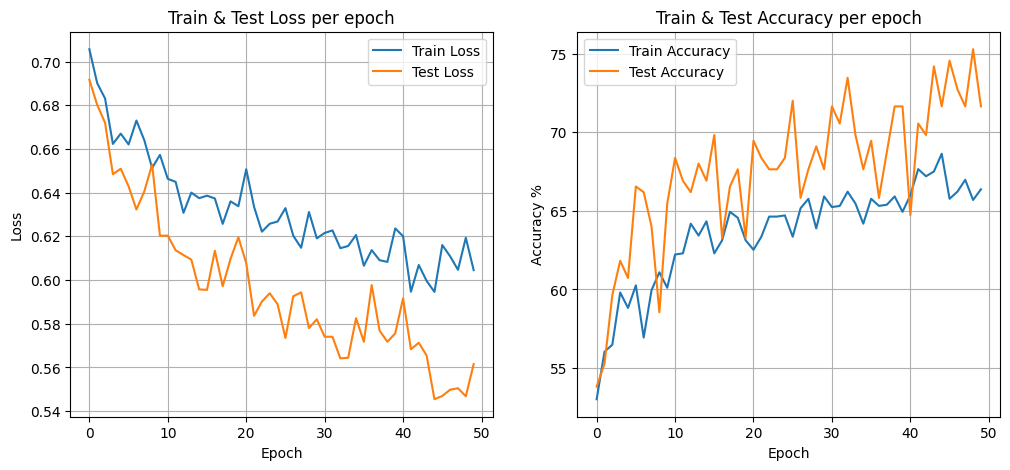

In [300]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), results["train_loss"], label="Train Loss")
plt.plot(range(epochs), results["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Test Loss per epoch")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), results["train_acc"], label="Train Accuracy")
plt.plot(range(epochs), results["test_acc"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy %")
plt.title("Train & Test Accuracy per epoch")
plt.legend()
plt.grid()

In [301]:
from torch.utils.data import Subset

In [302]:
train_100_images = Subset(train_data_augmentation, range(100))
test_20_images = Subset(test_data_augmentation, range(20))

len(train_100_images), len(test_20_images)

(100, 20)